У нас есть данные мобильного приложения (В2В) для постановки и отслеживания выполнения задач полевым сотрудникам. Выгрузка содержит:
- дата события.
- код заказчика.
- количество задач.

Попробуем на этих данных обучить обучить модель прогнозирования временных рядов с использованием FB Prophet.

In [1]:
import pandas as pd

from fbprophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from workalendar.europe import Russia
from sklearn.metrics import mean_absolute_percentage_error as mape

import warnings
warnings.filterwarnings('ignore')

Установим начальные данные:
- даты между которыми у нас есть актуальные данные.
- количество дней для прогноза.
- праздники РФ за последние 3 года (встроенные в prophet оказались не полными).

In [2]:
first_date = pd.to_datetime('2020-01-01')
last_date = pd.to_datetime('2021-06-25')
predictions = 30

ru_holidays = Russia()
hd_list = ru_holidays.holidays(2019) + ru_holidays.holidays(2020) + ru_holidays.holidays(2021)
hdays = pd.DataFrame(hd_list, columns=['ds', 'holiday'])
hdays['ds'] = pd.to_datetime(hdays['ds'])

Подготовим данные для обучения:
- загрузим файл.
- оставим нужный период.
- сгуппируем данные:
    - По умолчанию Профет ожидает получить 2 колонки "y", "ds".
    - Дополнительно у нас есть регрессор: количество заказчиков которые работали в этот день.
- отложим последние 30 дней (hold-out) для тестирования.

In [3]:
df = pd.read_csv('tasks_count.csv')
df['date'] = pd.to_datetime(df['date'])

df = df.loc[df['date'] <= last_date]
df = df.loc[df['date'] >= first_date]

agg_df = df.groupby('date').agg({'count':'sum', 'platform':'nunique'}).reset_index()
agg_df.columns = ['ds', 'y', 'platform']

train_df = agg_df[:-predictions]

Обучим дефолтную модель в качестве бэйслайна.

In [4]:
model = Prophet()
model.fit(train_df)

future = model.make_future_dataframe(periods=predictions)

forecast = model.predict(future)

mape(agg_df['y'], forecast['yhat'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26.08207851047618

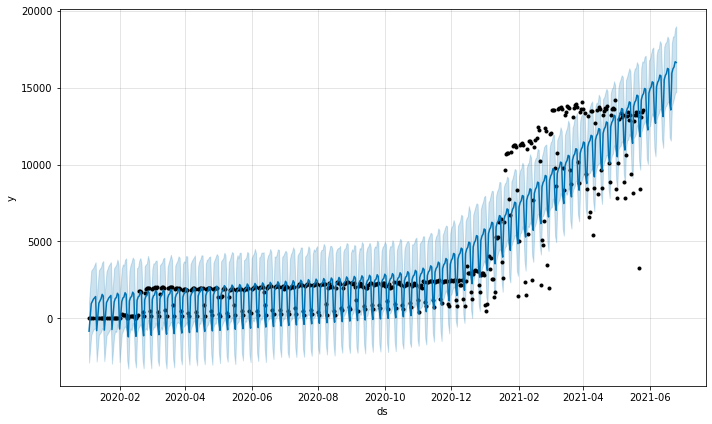

In [5]:
model.plot(forecast);

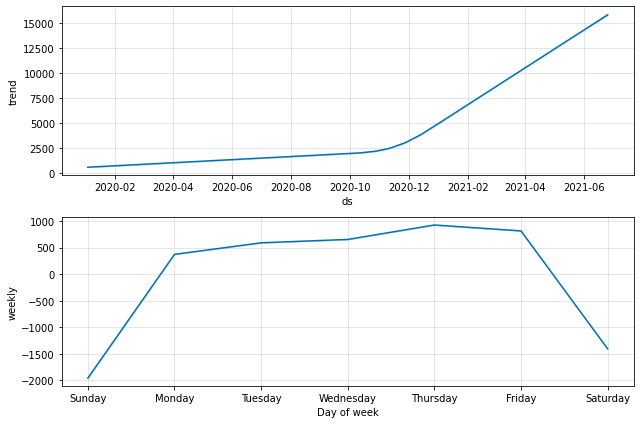

In [6]:
model.plot_components(forecast);

По графикам видно:
- линия тренда не достаточно гибкая для отслеживания изменений.
- по умолчанию Профет нашел только недельную сезонность.
- с ростом количества задач, увеличивается разброс. возможно это выходные дни и у разных заказчиков разные графики работы.

Усложним модель:
- добавим праздники.
- добавим гибкости линии тренда.
- установим 'multiplicative' вариант сезонности, он позволит сезонности меняться со временем.
- добавим дополнительный регрессор.


Значение параметров модели подбиралось вручную.
- для готовой сезонности мало данных.
- добавление месячной сезонности не дало улучшений метрики.

In [7]:
model = Prophet(
    holidays=hdays,
    changepoint_prior_scale=3,
    seasonality_mode='multiplicative'
)

model.add_regressor('platform')
# model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)

future = model.make_future_dataframe(periods=predictions)
future['platform'] = agg_df['platform']
forecast = model.predict(future)

mape(agg_df['y'], forecast['yhat'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2.042532563945868

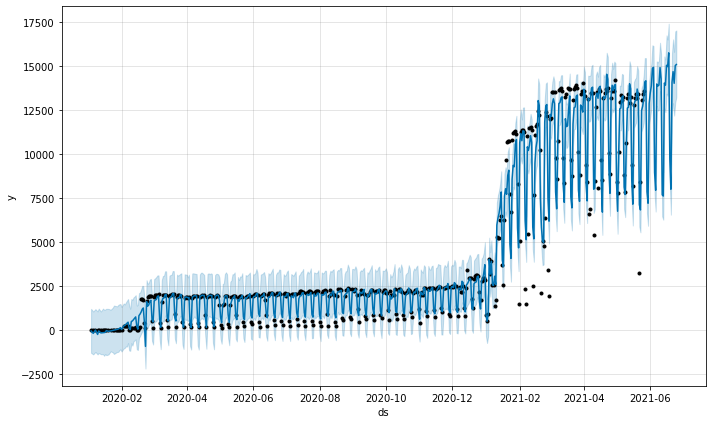

In [8]:
model.plot(forecast);

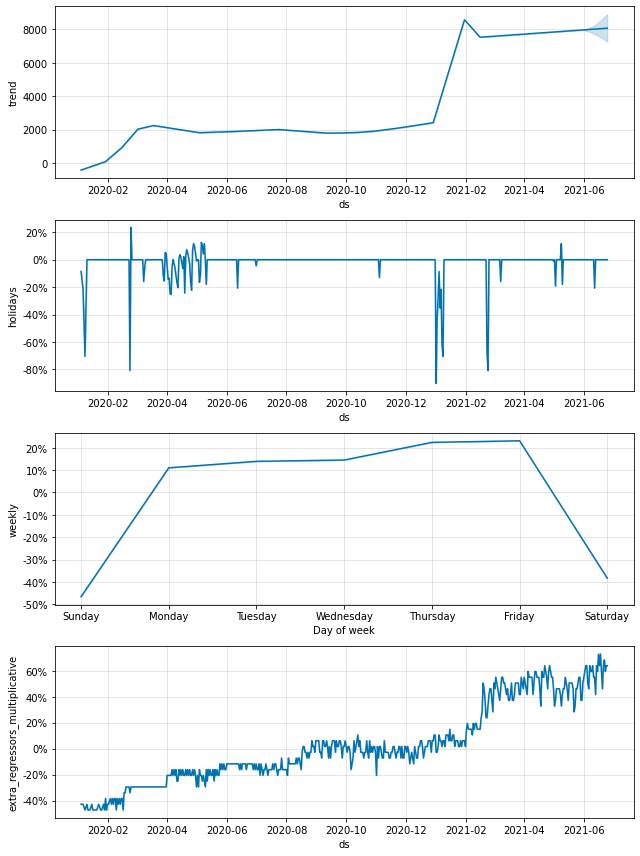

In [9]:
model.plot_components(forecast);

Подбор гиперпараметров позволил сократить MAPE в 10 раз, до 2%.

Оценим модель кросс-валидацией. Оставим первые 180 дней для обучения. Далее каждые 30 дней будем прогнозировать селедующие 30 дней.

INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-30 00:00:00 and 2021-04-26 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

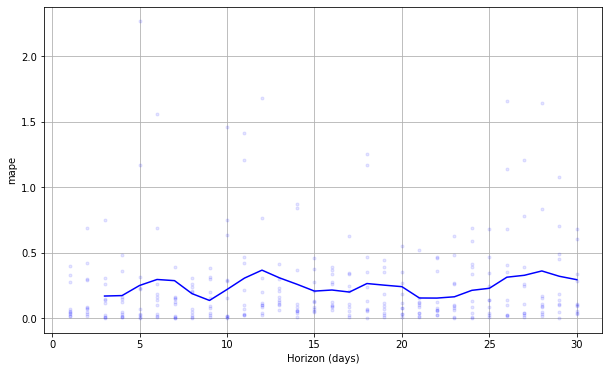

In [10]:
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon = '30 days')

plot_cross_validation_metric(df_cv, metric='mape');

### Выводы
- Prophet оказался достаточно простым для освоения.
- При этом достаточно гибким в настройке.
- прогноз на горизонте в 30 дней оказался достаточно стабильным.

#### Дополнительные и интересные возможности:
- для тренда можно устанавливать ограничения роста (падения).
- для тренда можно вручную задавать даты, в которые были изменения серьезно повлиявшие на показатели. Это уменьшить гибкость тренда (changepoint_prior_scale) и сделать модель более стабильной.
- подбор гиперпараметров реализовать с помощью поиска по сетке.
- добавить стабильности регрессору, сделать плавающие окно в 7 дней.